In [2]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

%matplotlib inline
%config Completer.use_jedi=False

import os
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

from matplotlib import pyplot as plt

model_id = 2
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\GlaDOS/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [3]:
net.eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature);

In [4]:
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [5]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [6]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

IMG_URL = "https://image.shutterstock.com/image-photo/pets-260nw-364732025.jpg"
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('./images/test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))

logit = net(img_variable)
h_x = F.softmax(logit, dim=1).data.squeeze(0)
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [7]:
for i in range(0, 5):
    print('{} -> {}'.format(probs[i], classes[idx[i]]))

0.41017013788223267 -> tabby, tabby cat
0.07128983736038208 -> tiger cat
0.041559163480997086 -> Egyptian cat
0.02756313607096672 -> tennis ball
0.020488860085606575 -> Rhodesian ridgeback


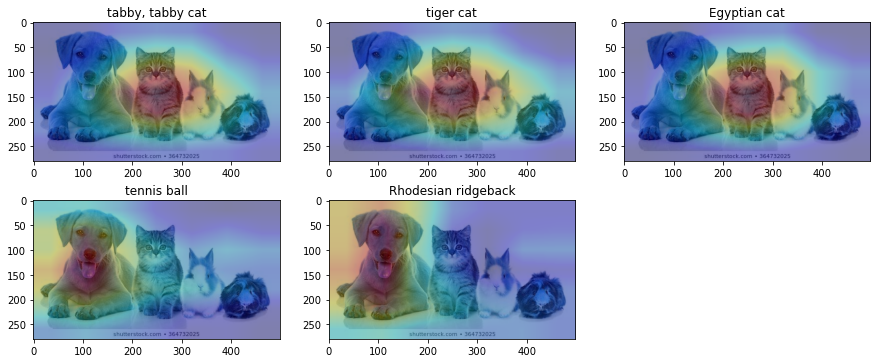

In [8]:
CAMs = returnCAM(features_blobs[0], weight_softmax, idx[:5])

img = cv2.imread('./images/test.jpg')

height, width, _ = img.shape

results = []

fig = plt.figure(figsize=(15, 6))
for i, cam in enumerate(CAMs):
    heatmap = cv2.cvtColor(cv2.applyColorMap(cv2.resize(cam, (width, height)), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)

    result = heatmap * 0.3 + img * 0.5  
    pil_img_cam = Image.fromarray(np.uint8(result))
    
    plt.subplot(2, 3, i + 1)
    
    plt.imshow(np.array(pil_img_cam))
    plt.title(classes[idx[i]])

In [23]:
import sys
sys.path.append('C:/Users/GlaDOS/mrnet')

import torch
import model
from dataloader import MRDataset
from tqdm import tqdm_notebook

task = 'acl'
plane = 'sagittal'
prefix = 'one'

model_name = [name  for name in os.listdir('models/') 
              if (task in name) and 
                 (plane in name) and 
                 (prefix in name)][0]

is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")

mrnet = torch.load(f'models/{model_name}')
mrnet = mrnet.to(device)

_ = mrnet.eval()

dataset = MRDataset('data/', 
                    task, 
                    plane, 
                    transform=None, 
                    train=False)
loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=1, 
                                     shuffle=False, 
                                     num_workers=0, 
                                     drop_last=False)

def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    slice_cams = []
    for s in range(bz):
        for idx in class_idx:
            cam = weight_softmax[idx].dot(feature_conv[s].reshape((nc, h*w)))
            cam = cam.reshape(h, w)
            cam = cam - np.min(cam)
            cam_img = cam / np.max(cam)
            cam_img = np.uint8(255 * cam_img)
            slice_cams.append(cv2.resize(cam_img, size_upsample))
    return slice_cams

In [24]:
patients = []

for i, (image, label, _) in tqdm_notebook(enumerate(loader), total=len(loader)):
    patient_data = {}
    patient_data['mri'] = image
    patient_data['label'] = label[0][0][1].item()
    patient_data['id'] = '0' * (4 - len(str(i))) + str(i)
    patients.append(patient_data)

acl = list(filter(lambda d: d['label'] == 1, patients))

C:\Users\GlaDOS\anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
import os
def create_patiens_cam(case, plane):
    patient_id = case['id']
    mri = case['mri']

    folder_path = f'CAMS/{plane}/{patient_id}/'
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)
    os.makedirs(folder_path + 'slices/')
    os.makedirs(folder_path + 'cams/')
    
    params = list(mrnet.parameters())
    weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
    
    num_slices = mri.shape[1]
    global feature_blobs
    feature_blobs = []
    mri = mri.to(device)
    logit = mrnet(mri)
    size_upsample = (256, 256)
    feature_conv = feature_blobs[0]
    
    h_x = F.softmax(logit, dim=1).data.squeeze(0)
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()
    slice_cams = returnCAM(feature_blobs[-1], weight_softmax, idx[:1])
    
    for s in tqdm_notebook(range(num_slices), leave=False):
        slice_pil = (transforms
                     .ToPILImage()(mri.cpu()[0][s] / 255))
        slice_pil.save(folder_path + f'slices/{s}.png', 
                       dpi=(300, 300))
         
        img = mri[0][s].cpu().numpy()
        img = img.transpose(1, 2, 0)
        heatmap = (cv2
                    .cvtColor(cv2.applyColorMap(
                        cv2.resize(slice_cams[s], (256, 256)),
                        cv2.COLORMAP_JET), 
                               cv2.COLOR_BGR2RGB)
                  )
        result = heatmap * 0.3 + img * 0.5  
        
        pil_img_cam = Image.fromarray(np.uint8(result))
        pil_img_cam.save(folder_path + f'cams/{s}.png', dpi=(300, 300))